# Introduction

The notebook consists of a setup section, the model training and the subsequent analysis. Due to time constraints we restrict ourselves to a comparison of different model aproaches that all use the full merger tree data vector to predict the final stellar mass of the root halo in the tree.

Due to resource constraints it generally uses 2 to 3 convolutional layers, which is shown to be sufficient by our hyperparameter analysis.

The hyperparameter analysis relies on tracking in MLflow which is an external tool that cannot be readily provided in the Notebook. We still show the application of Optuna and comment out the calls to MLflow.

# Setup

The following defines the imports and classes needed for training and analysis.

## Imports

In [12]:
from typing import Literal, Tuple, Union, Optional
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from accelerate import Accelerator

import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import (
    Linear,
    LayerNorm,
    LeakyReLU,
    Module,
    ReLU,
    Sequential,
    ModuleList,
    MSELoss,
)
from torch import (
    Tensor,
    cat,
    clone,
)


from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric import nn
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import OptTensor
from torch_geometric.utils import softmax
from torch_geometric.nn import GATv2Conv, global_add_pool, global_max_pool

## Model Classes

In order to easily parametrize the models we 

In [8]:
class MLP(Module):
    """Simple Multi-Layer Perceptron with ReLU activations and optional LayerNorm."""

    def __init__(
        self,
        n_in: int,
        n_out: int,
        hidden: int = 64,
        nlayers: int = 2,
        layer_norm: bool = True,
    ):
        """Initializes the MLP with the specified parameters.

        :param n_in: Number of input features
        :type n_in: int
        :param n_out: Number of output features
        :type n_out: int
        :param hidden: Number of hidden channels. Defaults to 64.
        :type hidden: int
        :param nlayers: Number of hidden layers. Defaults to 2.
        :type nlayers: int
        :param layer_norm: Whether to apply layer normalization. Defaults to True
        :type layer_norm: bool
        """
        super().__init__()

        layers = [Linear(n_in, hidden), ReLU()]
        for _ in range(nlayers):
            layers.append(Linear(hidden, hidden))
            layers.append(ReLU())
        if layer_norm:
            layers.append(LayerNorm(hidden))
        layers.append(Linear(hidden, n_out))
        self.mlp = Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


class Mangrove(Module):
    """Graph Neural Network model using customizable message passing layers and MLP en- and decoders.

    Generalization of the GraphSAGE based Mangrove model with options for encoding, decoding, and optional virtual node aggregation.

    Omits the original Mangrove's variance and covariance prediction features for simplicity, but they can be reintroduced if needed.
    """

    def __init__(
        self,
        hidden_channels: int,
        in_channels: int,
        out_channels: int,
        encode: bool = True,
        conv_layer: Union[type, list[type]] = GATv2Conv,
        conv_layer_kwargs: Union[dict, list[dict]] = {},
        num_conv_layers: int = 5,
        inject_virtual_node: bool = False,
        conv_activation: str = "relu",
        decode_layers: int = 3,
        decode_activation: str = "leakyrelu",
        layernorm: bool = True,
        agg: Literal["sum", "mean", "virt"] = "sum",
    ):
        """Initializes the Mangrove model with the specified parameters.

        :param hidden_channels: Number of hidden channels
        :type hidden_channels: int
        :param in_channels: Number of input channels
        :type in_channels: int
        :param out_channels: Number of output channels
        :type out_channels: int
        :param encode: Whether to encode node features before message passing. Defaults to True.
        :type encode: bool
        :param conv_layer: Message passing layer(s) to use. Defaults to GATv2Conv.
        :type conv_layer: Union[type, list[type]]
        :param conv_layer_kwargs: Keyword arguments for the convolutional layer(s). Defaults to {}.
        :type conv_layer_kwargs: Union[dict, list[dict]]
        :param num_conv_layers: Number of convolutional layers. Defaults to 5.
        :type num_conv_layers: int
        :param inject_virtual_node: Whether to inject the virtual node only in final convolution layer. Defaults to False.
        :type inject_virtual_node: bool
        :param conv_activation: Activation function for convolutional layers. Defaults to "relu".
        :type conv_activation: str
        :param decode_layers: Number of decoding layers. Defaults to 3.
        :type decode_layers: int
        :param decode_activation: Activation function for decoding layers. Defaults to "leakyrelu".
        :type decode_activation: str
        :param layernorm: Whether to apply layer normalization. Defaults to True.
        :type layernorm: bool
        :param agg: Aggregation method ("sum", "mean", or "virt"). Defaults to "sum".
        :type agg: Literal["sum", "mean", "virt"]

        """
        super(Mangrove, self).__init__()
        self.encode = encode
        self.decode_activation = decode_activation
        self.inject_virtual_node = inject_virtual_node
        self.conv_activation = conv_activation
        self.layernorm = layernorm
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.agg = agg

        # whether or not to encode the node features before any message passing
        if self.encode:
            self.node_enc = MLP(in_channels, hidden_channels, layer_norm=True)

        ########################
        # Convolutional Layers #
        ########################

        self._setup_conv_layers(conv_layer, num_conv_layers, conv_layer_kwargs)

        ##################
        # Decode Layers #
        ##################

        self._setup_decode_layers(decode_layers)

        #####################
        # Activation Layers #
        #####################

        self.conv_act = self._select_conv_act_f()
        self.decode_act = self._select_decode_act_f()  ## could apply later

    def _setup_conv_layers(
        self,
        conv_layer: Union[MessagePassing, list[MessagePassing]],
        num_conv_layers: int,
        conv_layer_kwargs: Union[dict, list[dict]],
    ) -> None:
        self.convs = ModuleList()
        if isinstance(conv_layer, type):
            conv_layer = [conv_layer] * num_conv_layers

        for conv in conv_layer:
            assert conv.__base__ == MessagePassing, "Every conv_layer must be a subclass of MessagePassing"

        if isinstance(conv_layer_kwargs, dict):
            conv_layer_kwargs = [conv_layer_kwargs] * num_conv_layers

        # If encoding is enabled, first layer goes from hidden_channels to hidden_channels
        if self.encode:
            self.convs.append(
                conv_layer[0](
                    self.hidden_channels, self.hidden_channels, **conv_layer_kwargs[0]
                )
            )
        # else, first layer goes from in_channels to hidden_channels
        else:
            self.convs.append(
                conv_layer[0](
                    self.in_channels, self.hidden_channels, **conv_layer_kwargs[0]
                )
            )

        for layer, kwargs in zip(conv_layer[1:], conv_layer_kwargs[1:]):
            self.convs.append(
                layer(self.hidden_channels, self.hidden_channels, **kwargs)
            )

    def _setup_decode_layers(self, num_decode_layers: int) -> None:
        self.decoders = ModuleList()
        self.norms = ModuleList()
        for _ in range(self.out_channels):
            self.decoder = ModuleList()
            self.norm = ModuleList()
            for i in range(num_decode_layers - 1):
                self.norm.append(LayerNorm(normalized_shape=self.hidden_channels))
                self.decoder.append(Linear(self.hidden_channels, self.hidden_channels))
            ## if final layer, make layer with only one output
            self.norm.append(LayerNorm(normalized_shape=self.hidden_channels))
            self.decoder.append(Linear(self.hidden_channels, 1))

            self.decoders.append(self.decoder)
            self.norms.append(self.norm)

    def _select_conv_act_f(self):
        if self.conv_activation == "relu":
            print("RelU conv activation")
            act = ReLU()
            return act
        if self.conv_activation == "leakyrelu":
            print("LeakyRelU conv activation")
            act = LeakyReLU()
            return act
        if not self.conv_activation:
            raise ValueError("Please specify a conv activation function")

    def _select_decode_act_f(self):
        if self.decode_activation == "relu":
            print("RelU decode activation")
            act = ReLU()
            return act
        if self.decode_activation == "leakyrelu":
            print("LeakyRelU decode activation")
            act = LeakyReLU()
            return act
        if not self.decode_activation:
            print("Please specify a decode activation function")
            return None

    def forward(self, graph: Data) -> Tensor:
        """Forward pass of the Mangrove model.

        If virtual node injection is enabled, only original edges are used for message passing, 
        and virtual node edges are used for final aggregation with the final convolution layer.

        :param graph: Input graph data
        :type graph: Data

        :return: Output tensor after processing the data
        :rtype: Tensor
        """
        # get the data
        x, edge_index, batch = graph.x, graph.edge_index, graph.batch

        if self.inject_virtual_node:
            edge_index_all = edge_index.clone()
            edge_index = edge_index[
                :, graph.edge_type == 0
            ]  ## only use original edges for message passing
        # encode
        if self.encode:
            x = self.node_enc(x)

        # convolutions
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = self.conv_act(x)  ##choose whichever

        if self.inject_virtual_node:
            # only use virtual node connections for final aggregation
            edge_index = edge_index_all[:, graph.edge_type == 1]

        x = self.convs[-1](x, edge_index)
        x = self.conv_act(x)  ##choose whichever

        # aggregation
        if self.agg == "sum":  ## sum for physics
            x = global_add_pool(x, batch)
        if self.agg == "max":
            x = global_max_pool(x, batch)
        if self.agg == "virt":
            x = x[
                graph.ptr[1:] - 1
            ]  ## last node in each graph of the batch is virtual node

        # decoder
        x_out = []
        for norm, decode in zip(self.norms, self.decoders):
            x1 = clone(x)
            for n, d in zip(norm, decode):
                x1 = d(n(x1))
                x1 = self.decode_act(x1)
            x_out.append(x1)
        if self.agg == "virt":
            x_out = x_out[0]
        else:
            x_out = cat(x_out, dim=1)

        return x_out

class GATv2SoftConv(GATv2Conv):
    """ Modified GATv2 convolution layer with a softplus activation instead of LeakyReLU, 
        following `Neumeier et al. (2023) <https://arxiv.org/abs/2305.16196>`_.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        beta: float = 1.0,
        threshold: float = 20.0,
        **kwargs,
    ):
        """ Initialize the GATv2SoftConv layer.
        
        :param in_channels: Input feature dimensionality.
        :type in_channels: Union[int, Tuple[int, int]]
        :param out_channels: Output feature dimensionality.
        :type out_channels: int
        :param beta: the β value for the Softplus formulation. Default: 1.0
        :type beta: float
        :param threshold: values above this revert to a linear function. Default: 20.0
        :type threshold: float
        :param kwargs: Parameters for :class:`torch_geometric.nn.conv.GATv2Conv`.
        :type kwargs: dict
        """
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.beta = beta
        self.threshold = threshold

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: OptTensor,
                    index: Tensor, ptr: OptTensor,
                    dim_size: Optional[int]) -> Tensor:
        """ Modified edge update function that uses a softplus activation
        instead of the standard LeakyReLU.
        """
        x = x_i + x_j

        if edge_attr is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
            assert self.lin_edge is not None
            edge_attr = self.lin_edge(edge_attr)
            edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            x = x + edge_attr

        x = F.softplus(x, self.beta, self.threshold)
        alpha = (x * self.att).sum(dim=-1)
        alpha = softmax(alpha, index, ptr, dim_size)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

## Management Class

In [9]:
class SAMTree:
    """Class to handle training, validation, and testing of Mangrove models on datasets.

    Used to streamline the training process, manage data splits, and simplify hyperparameter
    optimization.
    """

    model: Mangrove

    data: Dataset
    test_split: float
    val_split: float
    train_data: Data
    val_data: Data
    test_data: Data
    train_loader: DataLoader
    val_loader: DataLoader
    test_loader: DataLoader

    n_epochs: int
    max_lr: float
    optimizer: torch.optim.Optimizer
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler

    n_feat: int
    n_targ: int

    l1_lambda: float
    l2_lambda: float

    silent: bool

    def __init__(
        self,
        model: Mangrove,
        data: Dataset = None,
        train_data: Data = None,
        val_data: Data = None,
        test_data: Data = None,
        n_epochs: int = 100,
        max_lr: float = 1e-3,
        val_split: float = 0.0,
        test_split: float = 0.2,
        l1_lambda: float = 0.0,
        l2_lambda: float = 0.0,
        silent: bool = False,
    ):
        """Initializes the SAMTree model manager with the specified parameters.

        :param model: Mangrove model to be trained
        :type model: Mangrove
        :param data: Dataset to be used for training, validation, and testing splits
        :type data: Dataset
        :param train_data: Predefined training data
        :type train_data: Data
        :param val_data: Predefined validation data
        :type val_data: Data
        :param test_data: Predefined testing data
        :type test_data: Data
        :param n_epochs: Number of training epochs
        :type n_epochs: int
        :param max_lr: Maximum learning rate for the optimizer
        :type max_lr: float
        :param val_split: Fraction of data to be used for validation
        :type val_split: float
        :param test_split: Fraction of data to be used for testing
        :type test_split: float
        :param l1_lambda: L1 regularization coefficient
        :type l1_lambda: float
        :param l2_lambda: L2 regularization coefficient
        :type l2_lambda: float
        :param silent: Whether to suppress output during training
        :type silent: bool
        """
        self.silent = silent
        self.model = model

        if data is not None:
            self.data = data
            self.val_split = val_split
            self.test_split = test_split
            self._init_split_data()
        else:
            self._init_passed_data(train_data, val_data, test_data)

        self.n_feat = self.train_data[0].x.shape[1]
        self.n_targ = len(self.train_data[0].y)

        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.max_lr = max_lr
        self._set_epochs(n_epochs)

        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        self.accelerator = Accelerator()
        self.device = self.accelerator.device

        (
            self.model,
            self.optimizer,
            self.test_loader,
            self.train_loader,
            self.val_loader,
        ) = self.accelerator.prepare(
            self.model,
            self.optimizer,
            self.test_loader,
            self.train_loader,
            self.val_loader,
        )

    def _init_split_data(self):
        self.train_data, self.val_data, self.test_data = torch.utils.data.random_split(
            self.data,
            [1 - self.val_split - self.test_split, self.val_split, self.test_split],
        )

        self.test_loader = DataLoader(
            self.test_data, batch_size=256, shuffle=0, num_workers=2
        )
        self.val_loader = DataLoader(
            self.val_data, batch_size=256, shuffle=0, num_workers=2
        )
        self.train_loader = DataLoader(
            self.train_data, batch_size=256, shuffle=1, num_workers=2
        )

    def _init_passed_data(self, train_data: Data, val_data: Data, test_data: Data):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        val_size = len(self.val_data) if self.val_data else 0
        test_size = len(self.test_data)
        total_size = len(self.train_data) + len(self.val_data) + len(self.test_data)
        self.test_split = test_size / total_size
        self.val_split = val_size / total_size

        self.train_loader = DataLoader(
            self.train_data, batch_size=256, shuffle=1, num_workers=2
        )
        self.val_loader = DataLoader(
            self.val_data, batch_size=256, shuffle=0, num_workers=2
        )
        self.test_loader = DataLoader(
            self.test_data, batch_size=256, shuffle=0, num_workers=2
        )

        self.n_feat = self.train_data[0].x.shape[1]
        self.n_targ = len(self.train_data[0].y)

    def _set_epochs(self, n_epochs: int):
        self.n_epochs = n_epochs
        self.lr_scheduler = OneCycleLR(
            self.optimizer,
            max_lr=1e-2,
            total_steps=self.n_epochs * len(self.train_loader),
            pct_start=0.15,
            final_div_factor=1e3,
        )

    def test(self):
        """Tests the model on the test dataset and returns targets and predictions."""
        return self.get_comparison_values(self.test_loader)

    def validate(self):
        """Validates the model on the validation dataset and returns targets and predictions."""
        return self.get_comparison_values(self.val_loader)

    def get_comparison_values(self, loader: DataLoader):
        """Gets the true values and predictions from the model for a given DataLoader.

        :param loader: DataLoader for the dataset to evaluate
        :type loader: DataLoader

        :return: Tuple of true values and predictions
        :rtype: Tuple[np.ndarray, np.ndarray]
        """
        ys, pred = [], []
        self.model.eval()
        ys = []
        with torch.no_grad():
            for data in loader:
                out = self.model(data)
                ys.append(data.y.view(-1, self.n_targ))
                pred.append(out)

        ys = torch.vstack(ys)
        pred = torch.vstack(pred)
        return ys.cpu().numpy(), pred.cpu().numpy()

    def train(self, epoch: int):
        """Trains the model for one epoch on the training dataset.

        :param epoch: Current epoch number
        :type epoch: int
        """
        self.model.train()
        return_loss = 0  # total loss
        err_loss = 0  # error loss (precision)
        for data in self.train_loader:
            out = self.model(data)
            loss = MSELoss()(out, data.y.view(-1, self.n_targ))
            err_loss += loss
            if self.l1_lambda != 0:
                l1_norm = float(
                    np.sum(
                        [
                            p.abs().sum().detach().cpu().numpy()
                            for p in self.model.parameters()
                        ]
                    )
                )
            else:
                l1_norm = 0
            if self.l2_lambda != 0:
                l2_norm = float(
                    np.sum(
                        [
                            p.abs().sum().detach().cpu().numpy() ** 2
                            for p in self.model.parameters()
                        ]
                    )
                )
            else:
                l2_norm = 0
            loss = loss + self.l1_lambda * l1_norm + self.l2_lambda * l2_norm
            return_loss += loss
            self.accelerator.backward(loss)
            self.optimizer.step()
            self.optimizer.zero_grad()
            self.lr_scheduler.step(epoch)

        return (
            return_loss,
            err_loss,
            self.l1_lambda * l1_norm,
            self.l2_lambda * l2_norm,
        )

    def run_training(self, output_freq: int = 2):
        """Runs the training process for the configured number of epochs.

        :param output_freq: Frequency of output during training. Defaults to 2.
        :type output_freq: int

        :return: Array of training statistics collected at specified intervals.
        :rtype: np.ndarray
        """
        precisionTree = []

        for epoch in tqdm(range(self.n_epochs)):
            trainloss, err_loss, l1_loss, l2_loss = self.train(epoch)
            if not self.silent:
                print(
                    f"{trainloss:.2E} total loss, {err_loss:.2E} coming from the precision and {l1_loss + l2_loss:2E} coming from regularization"
                )
            if epoch % output_freq == 0:
                ys, preds = self.test()
                rho = np.corrcoef(np.hstack(ys), np.hstack(preds))[0, 1]
                std = np.std(ys - preds, axis=0)
                mu = np.mean(ys - preds, axis=0)
                precisionTree.append(
                    (std, rho, mu, trainloss, err_loss, l1_loss, l2_loss)
                )
                if not self.silent:
                    print(
                        f"Epoch {epoch + 1}: sigma: {std[0]:.4f}, bias: {mu[0]:.4f}, Pearson correlation {rho:.4f}"
                    )

        out_dtype = [
            ("std", "f4"),
            ("rho", "f4"),
            ("mu", "f4"),
            ("trainloss", "f4"),
            ("err_loss", "f4"),
            ("l1_loss", "f4"),
            ("l2_loss", "f4"),
        ]
        return np.array(precisionTree, dtype=out_dtype)


## Misc Functions

In [11]:
def plot_sigma_progression(res, freq, ylim=(8.5e-2, None)):
    epochs = np.arange(1,len(res)*freq,freq)
    plt.plot(epochs, res['std'])
    plt.xlabel("Epoch")
    plt.ylabel("$\\sigma$")
    plt.yscale("log")
    plt.ylim(*ylim)
    plt.grid(which="both")

## Globals

In [ ]:
targets = [8]

with open('mangrove_colab/data/data25.pkl', 'rb') as f:
    data = pickle.load(f)

# Model Training

## GATv2

In order to understand which parts of the graph are important and if using attention improves we employ the GATv2 convolutions.

### Simple Replacement

The first approach simply replaced the GraphSAGE convolutions with GATv2.

In [ ]:
modelSimple = Mangrove(
    hidden_channels =128,
    in_channels = 43,
    out_channels = 1,
    num_conv_layers=2,
    encode=True,
    conv_layer_kwargs={"heads": 1, "concat": True},
    variance=False)
stSimple = SAMTree(modelSimple, [Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]) for d in data], n_epochs=200, silent=True)

In [ ]:
resSimple = stSimple.run_training()

In [120]:
with open("modelSimple.pkl".format(i), "wb") as modf:
    pickle.dump(modelSimple, modf)
with open("resSimple.pkl".format(i), "wb") as resf:
    pickle.dump(resSimple, resf)

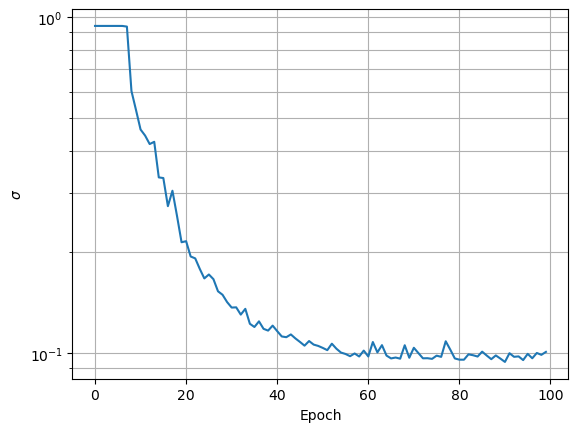

In [38]:
plot_sigma_progression(resSimple, 2)

### Softplus

Hoping to improve the performance of our GATv2 models we turned to the investigations of [Neumeier et al. (2023)](https://arxiv.org/abs/2305.16196) which suggested a number of improvements, among them 
1. splitting the weights between local and neighboring nodes,
2. asd
3. and replacing LeakyReLu with Softplus

The first two improvements were already set by default in GATv2, thus we only needed to introduce Softplus. The corresponding subclass `GATv2SoftConv` of `GATv2Conv` is defined above.

We try two linear thresholds without any descernible difference in final scatter.

### Thresh 20

In [75]:
modelSoft = Mangrove(
    hidden_channels =128,
    in_channels = 43,
    out_channels = 1,
    conv_layer= GATv2SoftConv,
    num_conv_layers=2,
    encode=True,
    conv_layer_kwargs={"heads": 1, "concat": True, "threshold": 20},
    variance=False)
stSoft = SAMTree(modelSoft, [Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]) for d in data], n_epochs=200, silent=True)

RelU conv activation
LeakyRelU decode activation


In [ ]:
resSoft = stSoft.run_training()
float(resSoft['std'].min())

In [ ]:
plot_sigma_progression(resSoft, 2)

### Thresh 100

In [ ]:
modelSoft100 = Mangrove(
    hidden_channels =128,
    in_channels = 43,
    out_channels = 1,
    conv_layer= GATv2SoftConv,
    num_conv_layers=2,
    encode=True,
    conv_layer_kwargs={"heads": 1, "concat": True, "threshold": 100},
    variance=False)
stSoft100 = SAMTree(modelSoft100, [Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]) for d in data], n_epochs=200, silent=True)

In [ ]:
resSoft100 = stSoft100.run_training()

In [ ]:
plot_sigma_progression(resSoft100, 2)

### With Virtual Node

In the following we apply a virutal node to the trees to test two things:
 1. To allow otherwise out of reach nodes to enter the receptive field of other nodes
 2. To represent the whole tree with a single node embedding

#### Add Virtual Nodes

In [112]:
import torch_geometric.transforms as trans
vnode_trans = trans.VirtualNode()
targets = [8]
data_set = [vnode_trans(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets])) for d in data]

#### Virtual Node as Peer in Message Passing

The simplest approach just treats the virtual node as any other node in GATv2 message passing, thus expanding the receptive field of each node for two hops to the whole graph.

In [ ]:
modelVirt = Mangrove(
    hidden_channels =128,
    in_channels = 43,
    out_channels = 1,
    num_conv_layers=2,
    encode=True,
    conv_layer_kwargs={"heads": 1, "concat": True},
    variance=False)
stVirt = SAMTree(modelVirt, data_set, n_epochs=200, silent=True)

In [ ]:
resVirt = stVirt.run_training()

In [120]:
with open("modelVirt.pkl".format(i), "wb") as modf:
    pickle.dump(modelVirt, modf)
with open("resVirt.pkl".format(i), "wb") as resf:
    pickle.dump(resVirt, resf)

In [ ]:
plot_sigma_progression(resVirt, 2)

#### Directly Decode the Virtual Node

The second use of a virtual node is to represent the whole tree in a single embedding. Here we try this approach with an otherwise unaltered model, i.e., the virtual node participates as a peer in the message passing.

In [5]:
modelVirtDirect = Mangrove(
    hidden_channels =128,
    in_channels = 43,
    out_channels = 1,
    num_conv_layers=2,
    encode=True,
    agg="virt",
    conv_layer_kwargs={"heads": 1, "concat": True},
    variance=False)

RelU conv activation
LeakyRelU decode activation


In [9]:
stVirtDirect = SAMTree(modelVirtDirect, data_set, n_epochs=200, silent=True)

/home/grimgorg/.conda/envs/cs224w-proj/lib/python3.13/site-packages/torch/utils/data/dataset.py:469: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


In [ ]:
resVirtDirect = stVirtDirect.run_training()

In [116]:
with open("modelVirtDirect.pkl".format(i), "wb") as modf:
    pickle.dump(modelVirtDirect, modf)
with open("resVirtDirect.pkl".format(i), "wb") as resf:
    pickle.dump(resVirtDirect, resf)

In [ ]:
plot_sigma_progression(resVirtDirect, 2)

In [110]:
float(resVirtDirect['std'].min())

np.float32(0.08849918)

#### 3xGraphSAGE and Final GATv2 Aggregation in the Virtual Node

Our last ansatz leaves out the virtual node for most of the message passing rounds and uses the last convolutional layer to aggregate the embeddings in the virtual node.

For simplicity and clarity we use GraphSAGE convolutions and only introduce one layer with attention in the final node.

This ansatz serves as basis for a deeper analysis for the location of high attention below.

In [ ]:
modelMixed = Mangrove(
    hidden_channels =128,
    in_channels = 43,
    out_channels = 1,
    conv_layer=[nn.SAGEConv, nn.SAGEConv, nn.SAGEConv, nn.GATv2Conv],
    inject_virtual_node=True,
    encode=True,
    agg="virt",
    conv_layer_kwargs=[{}]*3+[{"heads": 1, "concat": True}],
    variance=False)
stMixed = SAMTree(modelMixed, data_set, n_epochs=200, silent=True)

In [ ]:
resMixed = stMixed.run_training()

In [216]:
with open("modelMixed_200epochs.pkl".format(i), "wb") as modf:
    pickle.dump(modelMixed, modf)
with open("resMixed_200epochs.pkl".format(i), "wb") as resf:
    pickle.dump(resMixed, resf)

In [ ]:
resMixed = np.concat((resMixed, stMixed.run_training()))

In [218]:
with open("modelMixed_400epochs.pkl".format(i), "wb") as modf:
    pickle.dump(modelMixed, modf)
with open("resMixed_400epochs.pkl".format(i), "wb") as resf:
    pickle.dump(resMixed, resf)

##### With PE

In [199]:
with open('dataset_with_lapPE4.pkl', 'rb') as f:
    dataPE = pickle.load(f)

In [201]:
vnode_trans = trans.VirtualNode()
targets = [8]
data_setPE = [vnode_trans(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets])) for d in dataPE]

In [ ]:
modelMixedPE = Mangrove(
    hidden_channels =128,
    in_channels = 47,
    out_channels = 1,
    conv_layer=[nn.SAGEConv, nn.SAGEConv, nn.SAGEConv, nn.GATv2Conv],
    inject_virtual_node=True,
    encode=True,
    agg="virt",
    conv_layer_kwargs=[{}]*3+[{"heads": 1, "concat": True}],
    variance=False)
stMixedPE = SAMTree(modelMixedPE, data_setPE, n_epochs=200, silent=True)

In [ ]:
resMixedPE = stMixedPE.run_training()

In [219]:
with open("modelMixedPE_200epochs.pkl".format(i), "wb") as modf:
    pickle.dump(modelMixedPE, modf)
with open("resMixedPE_200epochs.pkl".format(i), "wb") as resf:
    pickle.dump(resMixedPE, resf)

In [ ]:
resMixedPE = np.concat((resMixedPE, stMixedPE.run_training()))

In [221]:
with open("modelMixedPE_400epochs.pkl".format(i), "wb") as modf:
    pickle.dump(modelMixedPE, modf)
with open("resMixedPE_400epochs.pkl".format(i), "wb") as resf:
    pickle.dump(resMixedPE, resf)

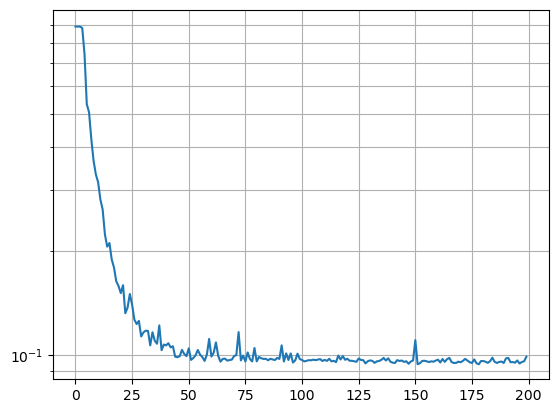

In [222]:
plot_sigma_progression(resMixedPE, 2)

In [ ]:
float(resMixedPE['std'].min())

##### Comparison

The addition of the positional encoding does not seem to have any benefit. On the contrary, our experiment shows that it actually increases the best value of the scatter.

In [ ]:
# plt.plot(resMixed["err_loss"])
plt.plot(np.arange(1,400,2), resMixed["std"], label="Basic Features")
plt.plot(np.arange(1,400,2), resMixedPE["std"], label="With PE, 4 EVs")
# plt.yscale("log")
plt.ylim(8e-2, 15e-2)
plt.xlim(0)
plt.grid(which='both')
plt.title("3x GraphSAGE + GATv2-Virtual-Aggregation")
plt.legend()
plt.ylabel("$\\sigma$")


## Optuna

To verify the choice of hyperparameters we ran an Optuna optimization with a pure GATv2 model and found very similar choices as the original authors for their GraphSAGE model.

The code below originally relied on MLflow for tracking the results. By commenting out the calls the code runs also without an MLflow instance and at any rate should be informative regarding the 

In [4]:
import optuna
# import mlflow

# mlflow.set_tracking_uri("http://localhost:5000")

def objective(trial):
    # with mlflow.start_run(nested=True):  ## !!! Changed indentation level !!!
        torch.cuda.empty_cache()
        # Define hyperparameters
        model_params = {
            "hidden_channels": trial.suggest_int("hidden_channels", 10, 256, log=False),
            "in_channels": 43,
            "out_channels": 1,
            "encode": trial.suggest_categorical("layernorm", [True, False]),
            "num_conv_layers": trial.suggest_int("num_conv_layers", 1, 4),
            "conv_activation": trial.suggest_categorical("conv_activation", ["relu", "leakyrelu"]),
            "decode_layers": trial.suggest_int("decode_layers", 1, 5),
            "decode_activation": trial.suggest_categorical("decode_activation", ["relu", "leakyrelu"]),
            "layernorm": trial.suggest_categorical("layernorm", [True, False])
        }

        st_params = {
            "l1_lambda": trial.suggest_float("l1_lambda", 1e-7, 10, log=True),
            "l2_lambda": trial.suggest_float("l2_lambda", 1e-7, 10, log=True),
            "max_lr": trial.suggest_float("max_lr", 1e-2, 5e-1, log=True),
        }

        model = Mangrove(**model_params)
        targets = [8]
        st = SAMTree(model, [Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]) for d in data[:]], val_split=0.1, silent=True, n_epochs=150, **st_params)

        res = st.run_training(output_freq=1)
        ys, preds, sigs, Mhalo = st.validate()
        rho = np.corrcoef(np.hstack(ys), np.hstack(preds))[0, 1]
        std = np.std(ys - preds, axis=0)
        mu = np.mean(ys - preds, axis=0)

        # Log to MLflow
        mlflow.log_params({**model_params, **st_params})
        mlflow.log_metrics({
            "std": std,
            "mu": mu,
            "rho": rho
        })

        fig = plt.figure()
        plt.plot(res)
        plt.xlabel("Epoch")
        plt.ylabel("$\\sigma$")
        plt.yscale("log")
        plt.grid(which="both")
        mlflow.log_figure(figure=fig, artifact_file="sigma.png")
        mlflow.log_dict(dictionary={"sigmas": res}, artifact_file="test_outputs.pkl")
        plt.close()

        return std

def champion_callback(study, frozen_trial):
  """
  Logging callback that will report when a new trial iteration improves upon existing
  best trial values.

  Note: This callback is not intended for use in distributed computing systems such as Spark
  or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
  workers or agents.
  The race conditions with file system state management for distributed trials will render
  inconsistent values with this callback.
  """

  winner = study.user_attrs.get("winner", None)

  if study.best_value and winner != study.best_value:
      study.set_user_attr("winner", study.best_value)
      if winner:
          improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
          print(
              f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
              f"{improvement_percent: .4f}% improvement"
          )
      else:
          print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [ ]:
# experiment_name = "SAMTree Basics"
# experiment = mlflow.get_experiment_by_name(experiment_name) or mlflow.create_experiment(experiment_name)

# # Initiate the parent run and call the hyperparameter tuning child run logic
# with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="First Attempt"):
  # Initialize the Optuna study
  study = optuna.create_study(direction="minimize")

  # Execute the hyperparameter optimization trials.
  # Note the addition of the `champion_callback` inclusion to control our logging
  study.optimize(objective, n_trials=100, callbacks=[champion_callback])

  # mlflow.log_params(study.best_params)
  # mlflow.log_metric("best_sigma", study.best_value)

  # # Log tags
  # mlflow.set_tags(
  #     tags={
  #         "project": "SAMTree",
  #         "optimizer_engine": "optuna",
  #         "model_family": "GNN",
  #         "feature_set_version": 1,
  #     }
  # )

# Analysis and Visualization

## Visualization of the Attention for the Mixed NxSAGE+GATv2 Approach and Direct Decoding of the Virtual Node

### Data Preparation

We first need to load the data and recover the attention values by traversing the model up to and including the GATv2 layer.

To locate nodes within the graph we calculate their distance from the root with the help of a DiGraph representation in `networkx`. The fraction of this depth divided by the maximum depth attained in a given graph is used as comparable coordinate later on and called *fractional depth*.

In [337]:
with open("modelMixed_200epochs.pkl", "rb") as mf:
    modelMixed = pickle.load(mf)

In [379]:
virt_attention = []
gens = []
for dat in tqdm(data_set[:]):
    a = dat.x.to("cuda")
    e = dat.edge_index.to("cuda")

    embeddings = modelMixed.node_enc(a)
    for conv in modelMixed.convs[:-1]:
        embeddings = conv(embeddings, e)

    embeddings2, (ei, attns) = modelMixed.convs[-1].forward(embeddings, e, return_attention_weights=True)

    attentions = attns.detach().cpu().numpy()
    edges = ei.cpu().numpy()

    virt_i = len(embeddings)-1
    virt_f = (edges[0] == virt_i) & (edges[1] != virt_i)

    virt_attention.append(np.bincount(edges[0], weights=attentions.flatten()*(edges[1]==virt_i)))

    DG = nx.DiGraph()
    DG.add_edges_from(edges[:, np.all(edges < virt_i, axis=0) & (edges[0] != edges[1])].T)

    gs = np.empty(DG.number_of_nodes(), "i4")
    for i, g in enumerate(nx.topological_generations(DG)):
        gs[g] = i
    gens.append(gs.max() - gs) 

### Number of Attended Nodes

The first visualization shows the number of nodes in a given graph above a given attention threshold, calculated as a multiple of the value for equal attention.

We test multiple thresholds and report the value for 0.1 in the paper.

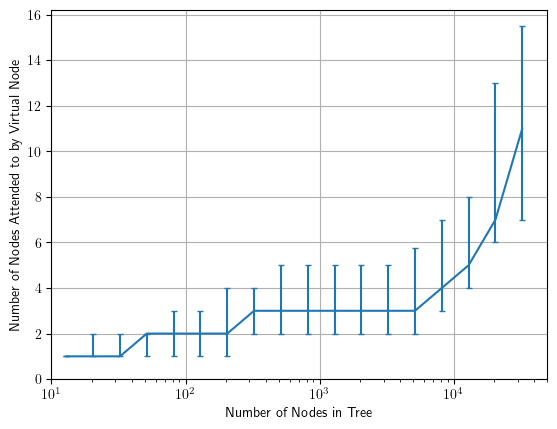

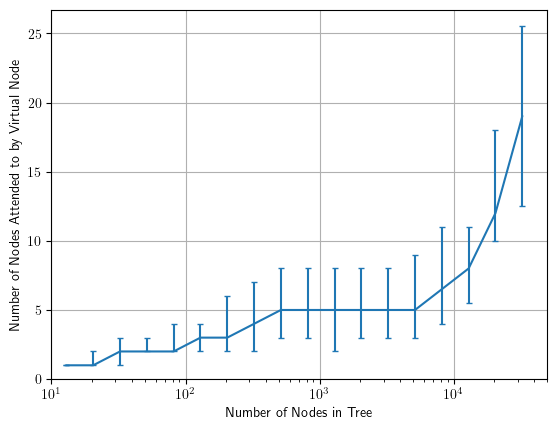

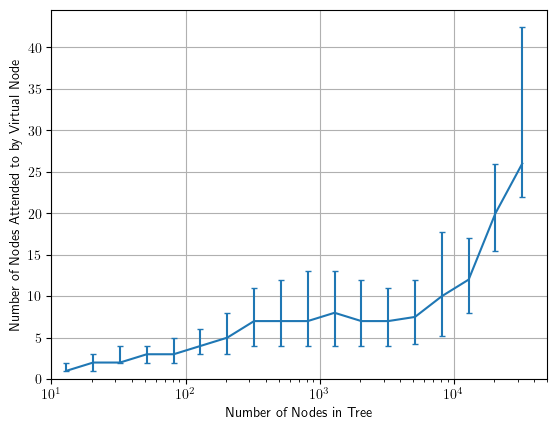

In [641]:
for t in [1,1e-1,1e-2]:
    num_attended = np.array([(len(v[:-1]), np.sum(v[:-1] > t/len(v[:-1]))) for v in virt_attention])
    be = np.logspace(1,5,4*5+1)
    bp = (be[:-1]+be[1:])/2
    m = stats.binned_statistic(num_attended.T[0], num_attended.T[1], statistic="median", bins=be)[0]
    p25 = stats.binned_statistic(num_attended.T[0], num_attended.T[1], statistic=lambda x: np.quantile(x,0.25), bins=be)[0]
    p75 = stats.binned_statistic(num_attended.T[0], num_attended.T[1], statistic=lambda x: np.quantile(x,0.75), bins=be)[0]

    plt.rc("text", usetex=True)
    plt.errorbar(bp, m, yerr=(m-p25, p75-m), capsize=2)
    plt.xlabel("Number of Nodes in Tree")
    plt.ylabel("Number of Nodes Attended to by Virtual Node")
    plt.xlim(1e1, 5e4)
    plt.ylim(0)
    plt.xscale("log")
    plt.grid()
    plt.show()
    plt.close()

### Total Attention over Depth

We then begin to locate the attention by checking the global share of attention in bin of fractional depth.

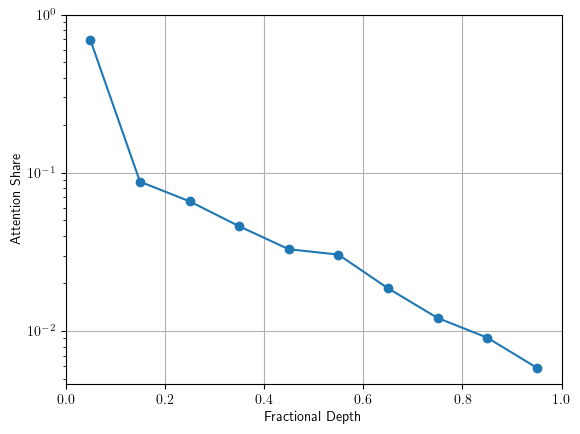

In [561]:
stats_all = []
be = np.linspace(0,1,11)
bp = (be[:-1]+be[1:])/2

for v,g in zip(virt_attention, gens):
    x = g/g.max()
    for label, at in {"Virt": v}.items():
        stats_all.append(stats.binned_statistic(x, at[:-1], "sum", be)[0])
    
stats_all = np.array(stats_all)
p25, p75  = np.nanpercentile(stats_all, [25,75], axis=0)
m = np.nanmean(stats_all, axis=0)
plt.plot(bp, m, "-o")
# plt.errorbar(bp, m, yerr=(m-p25, p75-m), label=label, capsize=2)
# plt.errorbar(bp, m, yerr=(m-p25, p75-m), capsize=2)
# plt.legend()
plt.grid()
plt.yscale("log")
plt.ylim(ymax=1)
plt.xlim(0,1)
plt.ylabel("Attention Share")
plt.xlabel("Fractional Depth")
plt.show()
plt.close()

### Amount of Attention in Root

Next, we show how much attention is in the root node, which is always the first node in a given graph.

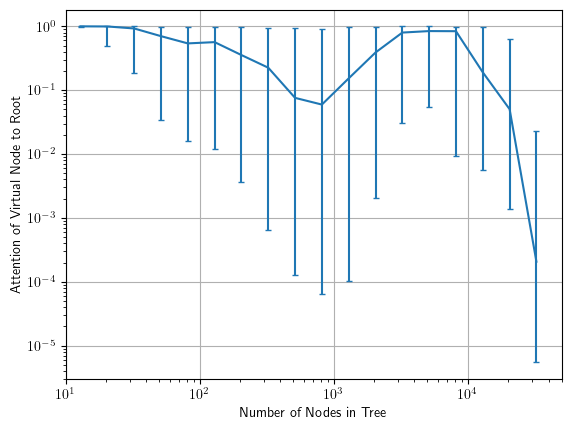

In [640]:
root_attention = np.array([(len(v[:-1]), v[0]) for v in virt_attention])
be = np.logspace(1,5,4*5+1)
bp = (be[:-1]+be[1:])/2
m = stats.binned_statistic(root_attention.T[0], root_attention.T[1], statistic="median", bins=be)[0]
p25 = stats.binned_statistic(root_attention.T[0], root_attention.T[1], statistic=lambda x: np.quantile(x,0.25), bins=be)[0]
p75 = stats.binned_statistic(root_attention.T[0], root_attention.T[1], statistic=lambda x: np.quantile(x,0.75), bins=be)[0]

plt.rc("text", usetex=True)
plt.errorbar(bp, m, yerr=(m-p25, p75-m), capsize=2)
plt.xlabel("Number of Nodes in Tree")
plt.ylabel("Attention of Virtual Node to Root")
plt.xlim(1e1, 5e4)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.show()
plt.close()

### Depth of 50\% Attention

To further understand the distribution over we find the depth at which point a given percentage of the attention is accumulated. For this we interpolate the cumulative sum of the attention over sorted depth and locate the minimum absolute difference to the target value. We calculate multiple thresholds but only report the 50% threshold in the report.

In [570]:
import scipy.interpolate as inter
import scipy.optimize as opt

In [611]:
levels = [1e-2,1e-1,0.25,0.5,0.75,0.9,0.99]
attention_level_depths = []
for i,(v,g) in enumerate(zip(virt_attention[:], gens[:])):
    depth_order = np.argsort(g)[::-1]
    intf = inter.interp1d(g[depth_order]/g.max(), v[depth_order].cumsum())
    attention_level_depths.append(tuple([len(g)] + 
                 [opt.minimize_scalar(lambda x: np.abs(intf(x) - l), bounds=[0,1], method="bounded")['x']
                  for l in levels]))
attention_level_depths = np.array(attention_level_depths, dtype=[("num", "i4")]+[("p%g"%l, "f4") for l in levels])

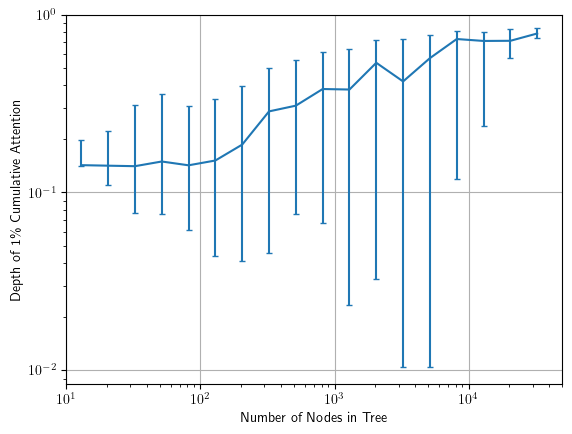

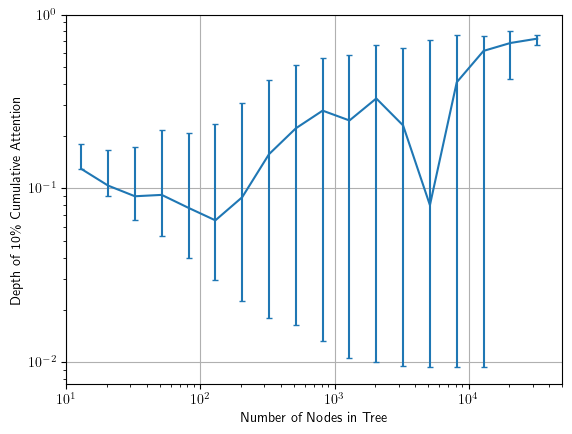

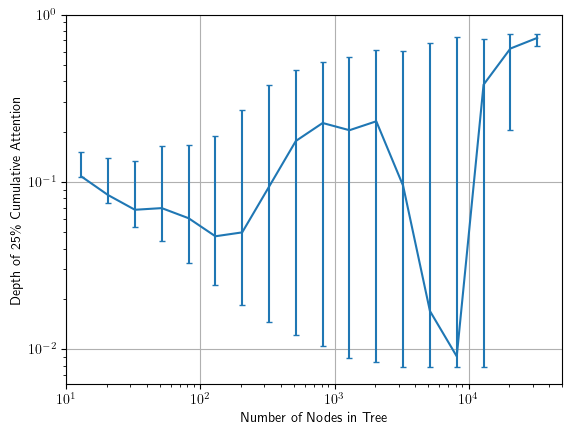

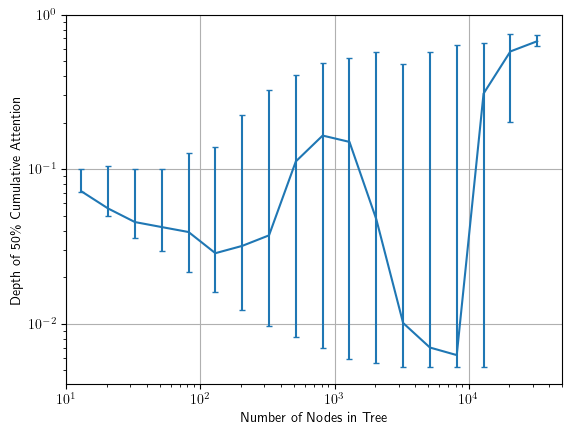

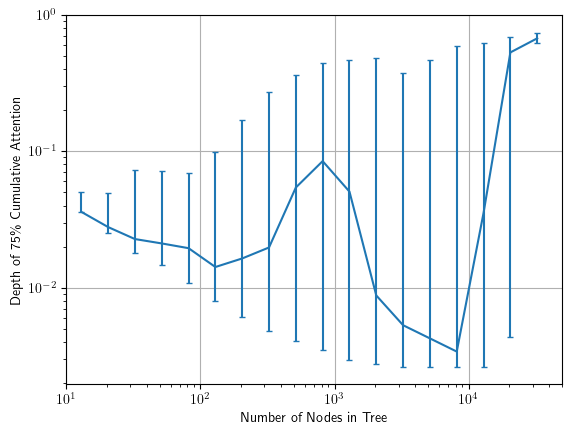

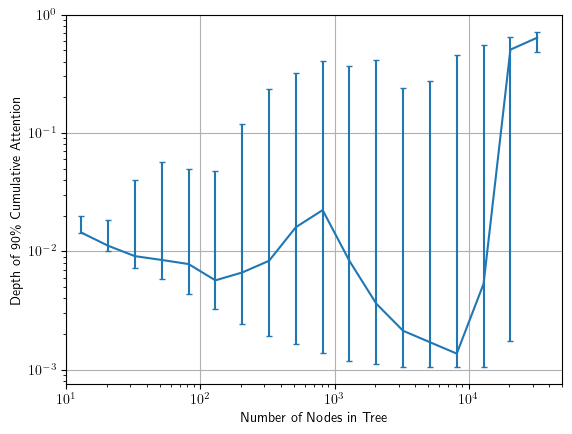

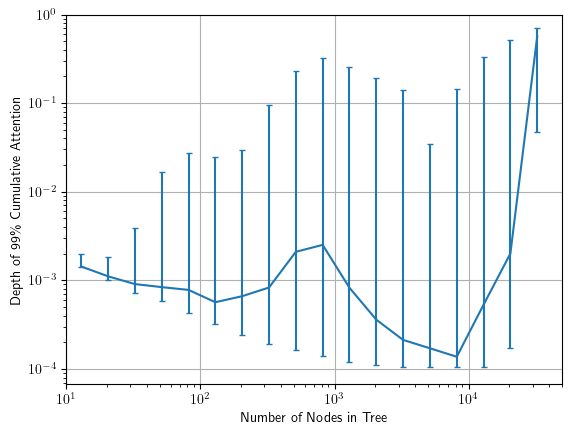

In [639]:
for name in attention_level_depths.dtype.names[1:]:
    lvl = int(round(float(name[1:])*100))
    be = np.logspace(1,5,4*5+1)
    bp = (be[:-1]+be[1:])/2
    m = stats.binned_statistic(attention_level_depths['num'], attention_level_depths[name], statistic="median", bins=be)[0]
    p25 = stats.binned_statistic(attention_level_depths['num'], attention_level_depths[name], statistic=lambda x: np.quantile(x,0.25), bins=be)[0]
    p75 = stats.binned_statistic(attention_level_depths['num'], attention_level_depths[name], statistic=lambda x: np.quantile(x,0.75), bins=be)[0]
    
    plt.rc("text", usetex=True)
    plt.errorbar(bp, m, yerr=(m-p25, p75-m), capsize=2)
    plt.xlabel("Number of Nodes in Tree")
    plt.ylabel("Depth of {:d}\% Cumulative Attention".format(lvl))
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e1, 5e4)
    plt.ylim(None, 1)
    plt.grid()
    plt.show()
    plt.close()

## Statistics

In order to assess the scatter between model runs, we ran the base GATv2 and GraphSAGE models with 2 convolutional layers 100 times.

<p style="font-size: xx-large;"><b>Beware of the long runtime!</b> These cells ran for <b>17 hours</b> on a NVIDIA GeForce RTX 2080 Ti</p>

### GATv2 Statistics

In [ ]:
import gc
targets = [8]
dat = [Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]) for d in data]
all_res = []
for i in range(100):
    model = Mangrove(
        hidden_channels =128,
        in_channels = 43,
        out_channels = 1,#data[0].y.shape[0],
        num_conv_layers=2,
        encode=True,
        conv_layer_kwargs={"heads": 1, "concat": True},
        variance=False)
    st = SAMTree(model, dat, n_epochs=100)
    res = st.run_training()
    all_res.append(res)

    with open("stats_runs/model_{:04d}.pkl".format(i), "wb") as modf:
        pickle.dump(model, modf)
    with open("stats_runs/res_{:04d}.pkl".format(i), "wb") as resf:
        pickle.dump(res, resf)

    del(model)
    gc.collect()
    torch.cuda.empty_cache()

com_res = np.array(all_res)
std_mini = tuple(np.array(tuple(enumerate(np.argmin(com_res['std'], axis=1)))).T)
loss_mini = tuple(np.array(tuple(enumerate(np.argmin(com_res['err_loss'], axis=1)))).T)

#### Scatter Statistics

Text(0.5, 0, 'std')

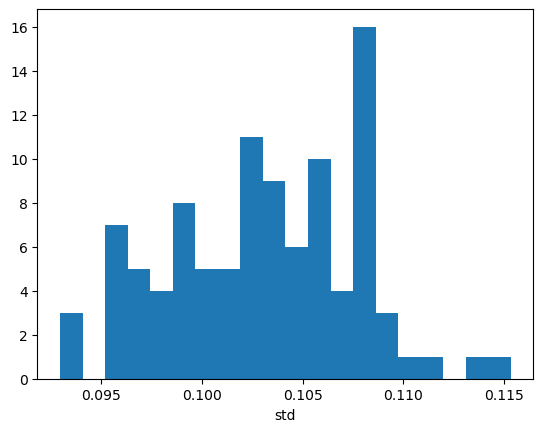

In [132]:
plt.title("Histogram of Minimum Scatter")
plt.hist(com_res['std'][std_mini], 20)
plt.xlabel("std")

In [133]:
m = np.mean(com_res['std'][std_mini],)
s = np.std(com_res['std'][std_mini],)
print(f"Summary statistics for scatter: Mean = {float(m)}, STD = {float(s)}, Rel. STD = {float(s/m)}"

(np.float32(0.10313723), np.float32(0.00473332), np.float32(0.045893416))

#### Loss Statistics

Text(0.5, 0, 'Loss')

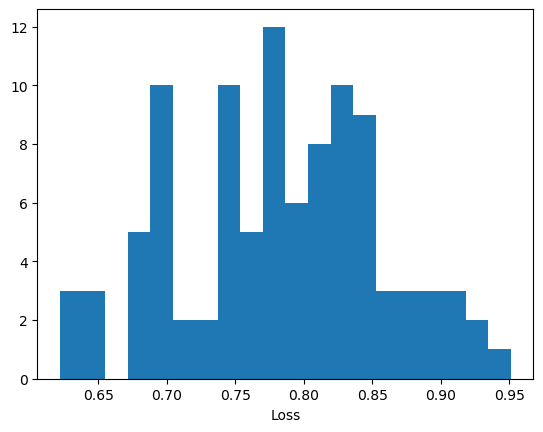

In [134]:
plt.title("Histogram of Minimum Loss")
plt.hist(com_res['err_loss'][loss_mini], 20)
plt.xlabel("Loss")

In [133]:
m = np.mean(com_res['std'][loss_mini],)
s = np.std(com_res['std'][loss_mini],)
print(f"Summary statistics for loss: Mean = {float(m)}, STD = {float(s)}, Rel. STD = {float(s/m)}"

(np.float32(0.10313723), np.float32(0.00473332), np.float32(0.045893416))

### GraphSAGE Baseline

In [ ]:
import gc
targets = [8]
dat = [Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]) for d in data]
all_res_sage = []
for i in range(0,100):
    model_sage = Mangrove(
        hidden_channels =128,
        in_channels = 43,
        out_channels = 1,
        num_conv_layers=2,
        conv_layer=nn.conv.SAGEConv,
        encode=True,
        variance=False)
    st_sage = SAMTree(model_sage, dat, n_epochs=100)
    res_sage = st_sage.run_training()
    all_res_sage.append(res_sage)

    with open("stats_runs/model_sage_{:04d}.pkl".format(i), "wb") as modf:
        pickle.dump(model_sage, modf)
    with open("stats_runs/res_sage_{:04d}.pkl".format(i), "wb") as resf:
        pickle.dump(res_sage, resf)

    del(model_sage)
    gc.collect()
    torch.cuda.empty_cache()

com_res_sage = np.array(all_res_sage)
std_mini = tuple(np.array(tuple(enumerate(np.argmin(com_res_sage['std'], axis=1)))).T)
loss_mini = tuple(np.array(tuple(enumerate(np.argmin(com_res_sage['err_loss'], axis=1)))).T)

#### Scatter Statistics

Text(0.5, 0, 'std')

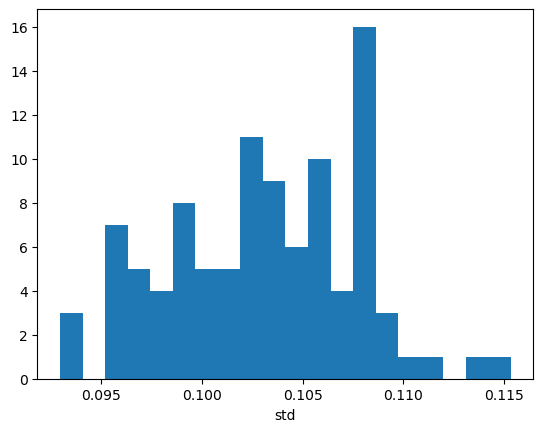

In [132]:
plt.title("Histogram of Minimum Scatter")
plt.hist(com_res_sage['std'][std_mini], 20)
plt.xlabel("std")

In [133]:
m = np.mean(com_res_sage['std'][std_mini],)
s = np.std(com_res_sage['std'][std_mini],)
print(f"Summary statistics for scatter: Mean = {float(m)}, STD = {float(s)}, Rel. STD = {float(s/m)}"

(np.float32(0.10313723), np.float32(0.00473332), np.float32(0.045893416))

#### Loss Statistics

Text(0.5, 0, 'Loss')

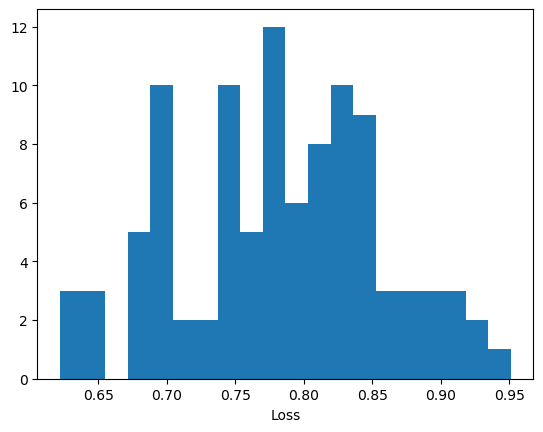

In [134]:
plt.title("Histogram of Minimum Loss")
plt.hist(com_res_sage['err_loss'][loss_mini], 20)
plt.xlabel("Loss")

In [133]:
m = np.mean(com_res_sage['std'][loss_mini],)
s = np.std(com_res_sage['std'][loss_mini],)
print(f"Summary statistics for loss: Mean = {float(m)}, STD = {float(s)}, Rel. STD = {float(s/m)}"

(np.float32(0.10313723), np.float32(0.00473332), np.float32(0.045893416))